In [1]:
from typing import Callable, Sequence, Tuple, Optional
from random import (sample, choices)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from scipy.stats import entropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os  #, sys, warnings, functools, math, time
from copy import deepcopy


def least_confidence(posterior: np.ndarray) -> np.ndarray:
  """Least confidence criterion, u(x) = 1 - max P(y | x).

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Least-confidence score.
  """
  return 1 - posterior.max(axis=1)


def entropy_criterion(posterior: np.ndarray) -> np.ndarray:
  """Entropy criterion, u(x) = -E[log P(y | x)].

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Entropy of the posterior distribution.
  """
  return entropy(posterior, axis=1)


def uncertainty_sampling(clf, X: np.ndarray, train_idx: Sequence[int], criterion: Callable[[np.ndarray], np.ndarray]) -> int:
  """Get the index of an unknown sample where the classifier is most uncertain about the label.

     Args:
        clf: The classifier (must provide `predict_proba()`).
        X: All data (labeled and unlabeled) - ndarray of shape (n_samples, n_features).
        train_idx: Indices of the training samples.
        criterion: Sample utility that maps posterior class probabilities to sample utility.

     Returns:
        Index of the sample in X with the highest decision uncertainty that is not yet in `train_idx`.
  """
  unknown_indices = np.array([i for i in range(X.shape[0]) if i not in train_idx])    # complement of train_idx
  posterior = clf.predict_proba(X[unknown_indices])
  utility = criterion(posterior)
  return unknown_indices[np.argmax(utility)]


In [36]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000,
    n_features=10,
    #n_informative=3,
    n_redundant=0,
    class_sep = 0.9,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    random_state=42,
    shuffle=False,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)
np.unique(y_train, return_counts=True)

(array([0, 1]), array([349, 351]))

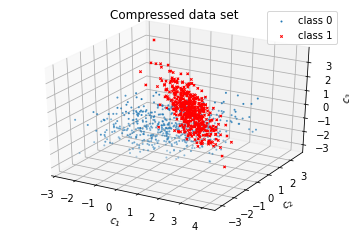

In [37]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(dataset)

X_reduce = TruncatedSVD(n_components=3).fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("Compressed data set")
ax.set_xlabel(r'$c_{1}$') ; ax.set_ylabel(r'$c_{2}$') ;ax.set_zlabel(r'$c_{3}$')
ax.scatter(X_reduce[y == 0, 0], X_reduce[y == 0, 1], zs=X_reduce[y == 0, 2], s=4, lw=0, label = "class 0")
# positives
ax.scatter(X_reduce[y == 1, 0], X_reduce[y == 1, 1], zs=X_reduce[y == 1, 2], 
           lw=1, s=6, marker="x", c="red", alpha=1, label = "class 1")
ax.legend()
plt.show();

In [52]:
#random.seed(112818)  # cherry-pick a seed of a bad example

train_idx = choices(range(X.shape[0]), k=int(X.shape[0]*.8))

clf = LogisticRegression().fit(X[train_idx], y[train_idx])
#clf = LogisticRegression().fit(X_train, y_train)
X_train = X[train_idx]
y_train = y[train_idx]

y_pred_train = clf.predict(X_train)

In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       389
           1       0.90      0.87      0.88       411

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



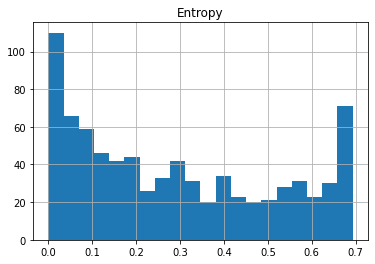

In [54]:
pd.DataFrame(entropy_criterion(clf.predict_proba(X_train)),columns=['Entropy']).hist(bins=20);

In [55]:
# ... do 8 rounds of uncertainty sampling
for round in range(8):
  new_sample = uncertainty_sampling(clf, X, train_idx, criterion = entropy_criterion)
  #new_sample = uncertainty_sampling(clf, X, train_idx, criterion = least_confidence)
  print(new_sample)
  train_idx.append(new_sample)

  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])

250
455
78
653
926
469
438
332


In [42]:
def density_weighted_uncertainty_sampling(clf, X: np.ndarray, precomputed_density: np.ndarray, beta: float, train_idx: Sequence[int], criterion: Callable[[np.ndarray], np.ndarray]) -> int:
  """Uncertainty sampling with density weighting.

     Args:
        clf: The classifier (must provide `predict_proba()`).
        X: All data (labeled and unlabeled) - ndarray of shape (n_samples, n_features).
        precomputed_densiy: Sample density for all samples in X - ndarray of shape (n_samples).
        beta: Weighting parameter.
        train_idx: Indices of the training samples.
        criterion: Sample utility that maps posterior class probabilities to sample utility.

     Returns:
        Index of the sample in X with the highest decision uncertainty that is not yet in `train_idx`.
  """
  unknown_indices = np.array([i for i in range(X.shape[0]) if i not in train_idx])
  posterior = clf.predict_proba(X[unknown_indices])
  utility = precomputed_density[unknown_indices]**beta * criterion(posterior)
  return unknown_indices[np.argmax(utility)]


In [43]:
from sklearn.neighbors import KernelDensity

#density = np.exp(KernelDensity().fit(X).score_samples(X))

In [44]:
from sklearn.mixture import (GaussianMixture, BayesianGaussianMixture)

#mix_model = GaussianMixture(n_components=50).fit(X)
mix_model = BayesianGaussianMixture(
    weight_concentration_prior_type="dirichlet_process", weight_concentration_prior = 1.1,  
    n_components = 50, reg_covar=0, init_params='random', covariance_type = 'diag',
    max_iter=1500, mean_precision_prior=.8,
    random_state=None).fit(X)

In [46]:
#x_sam, _ = mix_model.sample(5000)
#density = np.exp(mix_model.score_samples(x_sam))

density = np.exp(mix_model.score_samples(X))          # full sample!

In [56]:
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

# ... do 8 rounds of uncertainty sampling
for round in range(8):
  new_sample = density_weighted_uncertainty_sampling(clf, X, density, 1, train_idx, criterion = entropy_criterion)
  print(new_sample)
  train_idx.append(new_sample)

  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])        # update model

390
930
850
973
428
542
838
520


In [ ]:
!pip install modAL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# X, y = load_digits(return_X_y=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

# X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
# X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

In [ ]:
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier

# initializing the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training = X, y_training = y
)

# query for labels
query_idx, query_inst = learner.query(X_pool)

# ...obtaining new labels from the Oracle...

# supply label for queried instance
learner.teach(X_pool[query_idx], y_new)

NameError: ignored

In [ ]:
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from sklearn.ensemble import RandomForestClassifier

learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=entropy_sampling,
    X_training=X_training, y_training=y_training
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_EI, max_EI

%matplotlib inline

In [ ]:
import numpy as np

# generating the data
X = np.linspace(0, 20, 1000).reshape(-1, 1)
y = np.sin(X)/2 - ((10 - X)**2)/50 + 2

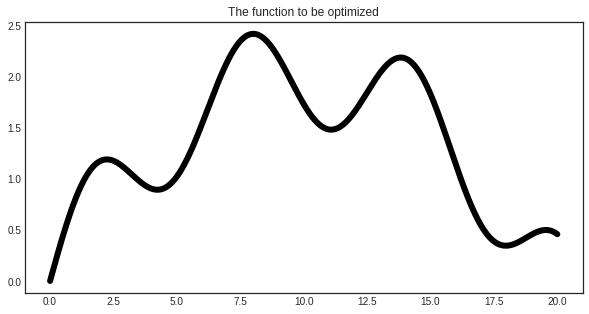

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(X, y, c='k', linewidth=6)
    plt.title('The function to be optimized')
    plt.show()

In [ ]:
# assembling initial training set
X_initial, y_initial = X[150].reshape(1, -1), y[150].reshape(1, -1)

# defining the kernel for the Gaussian process
kernel = Matern(length_scale=1.0)
regressor = GaussianProcessRegressor(kernel=kernel)

In [ ]:
# initializing the optimizer
optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=X_initial, y_training=y_initial,
    query_strategy=max_EI
)

In [ ]:
# Bayesian optimization : 5 queries
for n_query in range(5):
    query_idx, query_inst = optimizer.query(X)
    optimizer.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))   # update posterior
    
    y_pred, y_std = optimizer.predict(X, return_std=True)
    y_pred, y_std = y_pred.ravel(), y_std.ravel()
    X_max, y_max = optimizer.get_max()
    print(X_max, y_max)


[2.36236236] [1.18469583]
[2.36236236] [1.18469583]
[6.20620621] [1.67369102]
[7.56756757] [2.36129701]
[7.56756757] [2.36129701]


In [ ]:
y_pred, y_std = optimizer.predict(X, return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()
X_max, y_max = optimizer.get_max()
print(X_max, y_max)

[7.56756757] [2.36129701]


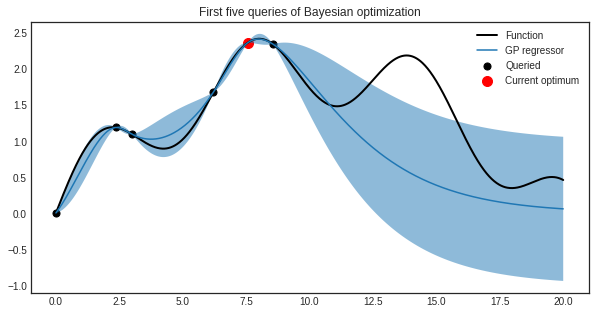

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.scatter(optimizer.X_training, optimizer.y_training, c='k', s=50, label='Queried')
    plt.scatter(X_max, y_max, s=100, c='r', label='Current optimum')
    plt.plot(X.ravel(), y, c='k', linewidth=2, label='Function')
    plt.plot(X.ravel(), y_pred, label='GP regressor')
    plt.fill_between(X.ravel(), y_pred - y_std, y_pred + y_std, alpha=0.5)
    plt.title('First five queries of Bayesian optimization')
    plt.legend()
    plt.show()